# HW 2 - Naive Bayes in Hadoop MR
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the live sessions for week 2 and week 3 you got some practice designing and debugging Hadoop Streaming jobs. In this homework we'll use Hadoop MapReduce to implement your first parallelized machine learning algorithm: Naive Bayes. As you develop your implementation you'll test it on a small dataset that matches the 'Chinese Example' in the _Manning, Raghavan and Shutze_ reading for Week 2. For the main task in this assignment you'll be working with a small subset of the Enron Spam/Ham Corpus. By the end of this assignment you should be able to:
* __... describe__ the Naive Bayes algorithm including both training and inference.
* __... perform__ EDA on a corpus using Hadoop MR.
* __... implement__ parallelized Naive Bayes.
* __... constrast__ partial, unordered and total order sort and their implementations in Hadoop Streaming.
* __... explain__ how smoothing affects the bias and variance of a Multinomial Naive Bayes model.

As always, your work will be graded both on the correctness of your output and on the clarity and design of your code. __Please refer to the `README` for homework submission instructions.__ 

## Notebook Setup
Before starting, run the following cells to confirm your setup.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming.jar"
HDFS_DIR = "/user/root/HW2/"
HOME_DIR = "" # FILL IN HERE eg. /media/notebooks/Assignments/HW2

In [3]:
# <--- SOLUTION --->
HOME_DIR = "/media/notebooks/Assignments/HW2/master"
HOME_DIR = "/media/notebooks/Instructors/Assignments/HW2/master" # for Instructors only

In [4]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [5]:
# data path
ENRON = "data/enronemail_1h.txt"

In [6]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -ls 
!hdfs dfs -mkdir {HDFS_DIR}

# Question 1: Hadoop MapReduce Key Takeaways.  

This assignment will be the only one in which you use Hadoop Streaming to implement a distributed algorithm. The key reason we continue to teach Hadoop streaming is because of the way it forces the programmer to think carefully about what is happening under the hood when you parallelize a calculation. This question will briefly highlight some of the most important concepts that you need to understand about Hadoop Streaming and MapReduce before we move on to Spark next week.   

### Q1 Tasks:

* __a) short response:__ What "programming paradigm" is Hadoop MapReduce based on? What are the main ideas of this programming paradigm and how does MapReduce exemplify these ideas?

* __b) short response:__ What is the Hadoop Shuffle? When does it happen? Why is it potentially costly? Describe one specific thing we can we do to mitigate the cost associated with this stage of our Hadoop Streaming jobs.

* __c) short response:__ In Hadoop Streaming why do the input and output record format of a combiner script have to be the same? [__`HINT`__ _what level of combining does the framework guarantee? what is the relationship between the record format your mapper emits and the format your reducer expects to receive?_]

* __d) short response:__ To what extent can you control the level of parallelization of your Hadoop Streaming jobs? Please be specific.

* __e) short response:__ What change in the kind of computing resources available prompted the creation of parallel computation frameworks like Hadoop? 

### Q1 Student Answers:

> __a)__ Type your answer here!  

> __b)__ Type your answer here!  

> __c)__ Type your answer here!  

> __d)__ Type your answer here!  

> __e)__ Type your answer here!  

### <--- SOLUTION --->
__SOLUTION__

> __a)__ Hadoop MapReduce is based on the functional programing paradigm. It is a declarative programming paradigm, which means programming is done with expressions. In functional code, the output value of a function depends only on the arguments that are input to the function. Key ideas in this paradigm include avoiding state changes/mutable data, and using higher-order functions (functions which take other functions as inputs). Map and reduce are examples of higher-order functions. 

> __b)__ The 'shuffle' is where Hadoop partitions, sorts, and copies data over the network to reducer nodes. Partitioning of the mapper output gurantees that records with the same key will be processed by the same reducer task. This is costly because of the network transfer required & the time complexity of doing a merge sort at scale. The key to mitigating the time/space cost of the shuffle is performing local aggregation either in memory in our mappers or by using a combiner.

> __c)__ Since Hadoop does not guarantee that a combiner will be executed, our record format has to work whether or not it goes through the combiner. In other words, the signature of the input and output of the combiner must match the signature of the input to the reducer. 

> __d)__ We can explicitly control the number of reducers used (for example by setting the `-numReduceTasks` parameter). But we can't force Hadoop to use the number of mappers we desire.

> __e)__ The rise of parallel computing frameworks was made possible by an increase in the availablility of cheap comodity hardware -- instead of investing in super computers the idea is to link together a lot of less powerful machines.

# Question 2: MapReduce Design Patterns.  

In the last two live sessions and in your readings from Lin & Dyer you encountered a number of techniques for manipulating the logistics of a MapReduce implementation to ensure that the right information is available at the right time and location. In this question we'll review a few of the key techniques you learned.   

### Q2 Tasks:

* __a) short response:__ What are counters (in the context of Hadoop Streaming)? How are they useful? What kinds of counters does Hadoop provide for you? How do you create your own custom counter?

* __b) short response:__ What are composite keys? How are they useful? How are they related to the idea of custom partitioning?

* __c) short response:__ What is the order inversion pattern? What problem does it help solve? How do we implement it? 

### Q2 Student Answers:

> __a)__ Type your answer here!  

> __b)__ Type your answer here!  

> __c)__ Type your answer here!  


### <--- SOLUTION --->
__SOLUTIONS__
> __a)__  Counters are a shared variable that is incremented and decremented atomically by the Hadoop framework. This means that all running instances within a job can update this variable to get a total count at the end. This is a departure from the principle of statelessness but is very useful for confirming that your jobs are running properly or aggregating summary statistics while performing other computations. The built in counters tell us information about IO, timing, and job orchestration. These are useful because such information can help you optimize your jobs. Especially useful are the Job Counters that tell you how many map, combine, and reduce tasks were run as well as the Map-Reduce Framework counters that tell you how many lines were input and output from your tasks. To create a custom counter we just write to standard output. For example:
 `sys.stderr.write("reporter:counter:MyWordCounter,count,1\n")`. It is important to keep in mind that counter values are not available to mapper and reducer functions, and are only exposed after the job has finished.
 
    
> __b)__ A composite key is when we package two pieces of information together to form the key that Hadoop will shuffle. This can be done by literally combining them as a string or by specifying that Hadoop should pay attention to two fields when shuffling. Composite keys are primarily useful when we want to control which sets of keys are shuffled to the same reducer node. In that scenario we  would 'combine' a partition key with our regular key to customize which records end up together.


> __c)__ The order inversion pattern is when we use a special key to ensure that some piece of information is processed before everthing else at the reduce stage. In some situations this can help us avoid a second shuffle, for example if you want to normalize values by a total but won't have access to the total until your sub-tallies are shuffled together.

# Question 3: Understanding Total Order Sort

The key challenge in distributed computing is to break a problem into a set of sub-problems that can be performed without communicating with each other. Ideally, we should be able to define an arbirtary number of splits and still get the right result, but that is not always possible. Parallelization becomes particularly challenging when we need to make comparisons between records, for example when sorting. Total Order Sort allows us to order large datasets in a way that enables efficient retrieval of results. Before beginning this assignment, make sure you have read and understand the [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb). You can skip the first two MRJob sections, but the rest of section III and all of section IV are **very** important (and apply to Hadoop Streaming) so make sure to read them closely. Feel free to read the Spark sections as well but you won't be responsible for that material until later in the course. To verify your understanding, answer the following questions.

### Q3 Tasks:

* __a) short response:__ What is the difference between a partial sort, an unordered total sort, and a total order sort? From the programmer's perspective, what does total order sort allow us to do that we can't with unordered total? Why is this important with large datasets?

* __b) short response:__ Which phase of a MapReduce job is leveraged to implement Total Order Sort? Which default behaviors must be changed. Why must they be changed?

* __c) short response:__ Describe in words how to configure a Hadoop Streaming job for the custom sorting and partitioning that is required for Total Order Sort.  

* __d) short response:__ Explain why we need to use an inverse hash code function.

* __e) short response:__ Where does this function need to be located so that a Total Order Sort can be performed?

### Q3 Student Answers:

> __a)__ Type your answer here!  

> __b)__ Type your answer here!  

> __c)__ Type your answer here!  

> __d)__ Type your answer here!  

> __e)__ Type your answer here!  

### <--- SOLUTION --->

__ SOLUTIONS __

> __a)__  The key thing that total order sort facillitates is the ability to sort with multiple reducers and the guarantee that the top N results will end up in the first partition. This is key because for really large data sets it would be time consuming to check all of the paritions to find the subset of the results you need.
>    - partial sort: Each partition file is sorted independently of each other. Concatentating such partitions would result in an unsorted file.
>    - unordered total sort: Partition files are all sorted according to the same key but there is no guarantee about which chunk of output is where. Concatenating these files would only result in a sorted file if the partitions were appropriately reordered.
>    - total ordered sort: An unordered total sort where a custom partitioner was used so that the output files are sorted in order according to output filename. Concatentaing these files would result in a single completely sorted file witout any further intervention.

> __b)__ The shuffle/sort phase is where the sorting functionality takes place. To implement Total Order Sort, we must override the default partitioning behavior. By default, Hadoop does an alphanumerically increasing sort on a single key field within each partition resulting in partial order sort.

> __c)__  The Hadoop Streaming job is configured via several command line options. To perform custom operations, the number of fields to consider for the key and the separator token between key fields must be specified if they are different from the default. For custom sorting, we must also speficy the comparator class along with the comparator options that control how each key field will be sorted, ie the order to consider fields and if they should be sorted numerically or in reverse. For custom partitioning, we must also specify the custom partitioner class along with which key field(s) to partition on.

> __d)__  The inverse hash code lets us know the actual key that Hadoop will use for partitioning. By knowing this, we can reorder the partition keys that we are using according to the order that they will be sorted in after being hashed. Without this, we cannot know which partition key to use for which partition so that they end result is ordered by file name.

> __e)__  The inverse hash function must be accesible before partitioning takes place. Hense, it needs to reside inside the mapper function.


# About the Data
For the main task in this portion of the homework you will train a classifier to determine whether an email represents spam or not. You will train your Naive Bayes model on a 100 record subset of the Enron Spam/Ham corpus available in the HW2 data directory (__`HW2/data/enronemail_1h.txt`__).

__Source:__   
The original data included about 93,000 emails which were made public after the company's collapse. There have been a number raw and preprocessed versions of this corpus (including those available [here](http://www.aueb.gr/users/ion/data/enron-spam/index.html) and [here](http://www.aueb.gr/users/ion/publications.html)). The subset we will use is limited to emails from 6 Enron employees and a number of spam sources. It is part of [this data set](http://www.aueb.gr/users/ion/data/enron-spam/) which was created by researchers working on personlized Bayesian spam filters. Their original publication is [available here](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf). __`IMPORTANT!`__ _For this homework please limit your analysis to the 100 email subset which we provide. No need to download or run your analysis on any of the original datasets, those links are merely provided as context._

__Preprocessing:__  
For their work, Metsis et al. (the authors) appeared to have pre-processed the data, not only collapsing all text to lower-case, but additionally separating "words" by spaces, where "words" unfortunately include punctuation. As a concrete example, the sentence:  
>  `Hey Jon, I hope you don't get lost out there this weekend!`  

... would have been reduced by Metsis et al. to the form:  
> `hey jon , i hope you don ' t get lost out there this weekend !` 

... so we have reverted the data back toward its original state, removing spaces so that our sample sentence would now look like:
> `hey jon, i hope you don't get lost out there this weekend!`  

Thus we have at least preserved contractions and other higher-order lexical forms. However, one must be aware that this reversion is not complete, and that some object (specifically web sites) will be ill-formatted, and that all text is still lower-cased.


__Format:__   
All messages are collated to a tab-delimited format:  

>    `ID \t SPAM \t SUBJECT \t CONTENT \n`  

where:  
>    `ID = string; unique message identifier`  
    `SPAM = binary; with 1 indicating a spam message`  
    `SUBJECT = string; title of the message`  
    `CONTENT = string; content of the message`   
    
Note that either of `SUBJECT` or `CONTENT` may be "NA", and that all tab (\t) and newline (\n) characters have been removed from both of the `SUBJECT` and `CONTENT` columns.  

In [6]:
!pwd

/media/notebooks/Assignments/HW2/master


In [7]:
# take a look at the first 100 characters of the first 5 records (RUN THIS CELL AS IS)
!head -n 5 /media/notebooks/Assignments/HW2/master/{ENRON} | cut -c-100

0001.1999-12-10.farmer	0	 christmas tree farm pictures	NA
0001.1999-12-10.kaminski	0	 re: rankings	 thank you.
0001.2000-01-17.beck	0	 leadership development pilot	" sally:  what timing, ask and you shall receiv
0001.2000-06-06.lokay	0	" key dates and impact of upcoming sap implementation over the next few week
0001.2001-02-07.kitchen	0	 key hr issues going forward	 a) year end reviews-report needs generating 


In [8]:
# see how many messages/lines are in the file 
#(this number may be off by 1 if the last line doesn't end with a newline)
!wc -l /media/notebooks/Assignments/HW2/master/{ENRON}

100 /media/notebooks/Assignments/HW2/master/data/enronemail_1h.txt


In [8]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -mkdir {HDFS_DIR}

mkdir: `/user/root/HW2': File exists


In [9]:
# load the data into HDFS (RUN THIS CELL AS IS)
!hdfs dfs -copyFromLocal /media/notebooks/Assignments/HW2/master/{ENRON} {HDFS_DIR}/enron.txt

In [10]:
!hdfs dfs -ls {HDFS_DIR}

Found 1 items
-rw-r--r--   1 root supergroup     204559 2020-01-02 16:08 /user/root/HW2/enron.txt


# Question 4:  Enron Ham/Spam EDA.
Before building our classifier, lets get aquainted with our data. In particular, we're interested in which words occur more in spam emails than in legitimate ("ham") emails. In this question you'll implement two Hadoop MapReduce jobs to count and sort word occurrences by document class. You'll also learn about two new Hadoop streaming parameters that will allow you to control how the records output from your mappers are partitioned for reducing on separate nodes. 

__`IMPORTANT NOTE:`__ For this question and all subsequent items, you should include both the subject and the body of the email in your analysis (i.e. concatetate them to get the 'text' of the document).

### Q4 Tasks:
* __a) code:__ Complete the missing components of the code in __`EnronEDA/mapper.py`__ and __`EnronEDA/reducer.py`__ to create a Hadoop  MapReduce job that counts how many times each word in the corpus occurs in an email for each class. Pay close attention to the data format specified in the docstrings of these scripts _-- there are a number of ways to accomplish this task, we've chosen this format to help illustrate a technique in `part e`_. Run the provided unit tests to confirm that your code works as expected, then run the provided Hadoop Streaming command to apply your analysis to the Enron data.


* __b) code + short response:__ How many times does the word "__assistance__" occur in each class? (`HINT:` Use a `grep` command to read from the results file you generated in '`a`' and then report the answer in the space provided.)


* __c) short response:__ Would it have been possible to add some sorting parameters to the Hadoop streaming command that would cause our `part a` results to be sorted by count? Explain why or why not. (`HINT:` This question demands an understanding of the sequence of the phases of MapReduce.)


* __d) code + short response:__ Write a second Hadoop MapReduce job to sort the output of `part a` first by class and then by count. Run your job and save the results to a local file. Then describe in words how you would go about printing the top 10 words in each class given this sorted output. (`HINT 1:` _remember that you can simply pass the `part a` output directory to the input field of this job; `HINT 2:` since this task is just reodering the records from `part a` we don't need to write a mapper or reducer, just use `/bin/cat` for both_)


* __e) code:__ A more efficient alternative to '`grep`-ing' for the top 10 words in each class would be to use the Hadoop framework to separate records from each class into its own partition so that we can just read the top lines in each. Rewrite your job from ` part d` to specify 2 reduce tasks and to tell Hadoop to partition based on the second field (which indicates spam/ham in our data). Your code should maintain the secondary sort -- that is each partition should list words from most to least frequent.

### Q4 Student Answers:
> __b)__ Type your answer here!  

> __c)__ Type your answer here!  

> __d)__ Type your answer here!  

### <--- SOLUTION --->

__ SOLUTIONS __
> __b)__ 'assistance' occurs 8 times in Spam emails and only 2 times in real emails.  

> __c)__ No, we can't sort on counts in the original job because Hadoop's sorting occurs in the phase between the mapper and reducer but our counts aren't tallied up until after the reducer.

> __d)__ The result of this job is sorted by count with each word getting two records (one for 'spam' and one for 'ham'). To get the top counts in each class we could grep for the class marker that is listed in the second field. This is an non-ideal solution because the class markers (0 and 1) will also occur inside counts for other words).

In [11]:
# part a - do your work in the provided scripts then RUN THIS CELL AS IS
!chmod a+x EnronEDA/mapper.py
!chmod a+x EnronEDA/reducer.py

In [13]:
# part a - unit test EnronEDA/mapper.py (RUN THIS CELL AS IS)
!echo -e "d1	1	title	body\nd2	0	title	body" | EnronEDA/mapper.py

title	1	1
body	1	1
title	0	1
body	0	1


In [14]:
# part a - unit test EnronEDA/reducer.py (RUN THIS CELL AS IS)
!echo -e "one	1	1\none	0	1\none	0	1\ntwo	0	1" | EnronEDA/reducer.py

one	1	1
one	0	2
two	1	0
two	0	1


In [15]:
# part a - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

rm: `/user/root/HW2/eda-output': No such file or directory


In [16]:
# part a - Hadoop streaming job (RUN THIS CELL AS IS)
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob8593711182674269150.jar tmpDir=null
19/08/23 15:37:39 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 15:37:39 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 15:37:40 INFO mapred.FileInputFormat: Total input paths to process : 1
19/08/23 15:37:40 INFO mapreduce.JobSubmitter: number of splits:2
19/08/23 15:37:40 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1566574597904_0001
19/08/23 15:37:41 INFO impl.YarnClientImpl: Submitted application application_1566574597904_0001
19/08/23 15:37:41 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1566574597904_0001/
19/08/23 15:37:41 INFO mapreduce.Job: Running job: job_1566574597904_0001
19/08/23 15:37:50 INFO mapreduce.Job: Job job_1566574597904_0001 running in uber mode : false
19/08/23 15:37:50 INFO mapreduce.Job:  map 0% reduce 0%
19/08

In [17]:
# part a - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/eda-output/part-0000* > EnronEDA/results.txt

In [18]:
# part b - write your grep command here

In [19]:
# <--- SOLUTION --->
# part b - write your grep command here
!grep assistance EnronEDA/results.txt

assistance	1	8
assistance	0	2


In [20]:
# part d - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

rm: `/user/root/HW2/eda-sort-output': No such file or directory


In [70]:
# part d - write your Hadoop streaming job here

In [21]:
# <--- SOLUTION --->
# part d - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2 -k3,3nr" \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -input {HDFS_DIR}/eda-output \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob851423651156958352.jar tmpDir=null
19/08/23 15:38:35 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 15:38:35 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 15:38:36 INFO mapred.FileInputFormat: Total input paths to process : 2
19/08/23 15:38:36 INFO mapreduce.JobSubmitter: number of splits:2
19/08/23 15:38:36 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1566574597904_0002
19/08/23 15:38:36 INFO impl.YarnClientImpl: Submitted application application_1566574597904_0002
19/08/23 15:38:36 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1566574597904_0002/
19/08/23 15:38:36 INFO mapreduce.Job: Running job: job_1566574597904_0002
19/08/23 15:38:42 INFO mapreduce.Job: Job job_1566574597904_0002 running in uber mode : false
19/08/23 15:38:42 INFO mapreduce.Job:  map 0% reduce 0%
19/08/

In [ ]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

In [ ]:
# part e - write your Hadoop streaming job here

In [ ]:
# <--- SOLUTION --->
# part e - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k3,3nr" \
  -D mapreduce.partition.keypartitioner.options="-k2,2" \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -input {HDFS_DIR}/eda-output \
  -output {HDFS_DIR}/eda-sort-output \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

In [22]:
# part e - view the top 10 records from each partition (RUN THIS CELL AS IS)
for idx in range(2):
    print(f"\n===== part-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-0000{idx} | head


===== part-00000=====

the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135	
cat: Unable to write to output stream.

===== part-00001=====

the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153	
cat: Unable to write to output stream.


__Expected output:__
<table>
<th>part-00000:</th>
<th>part-00001:</th>
<tr><td><pre>
the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135
</pre></td>
<td><pre>
the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153
</pre></td></tr>
</table>

# Question 5: Counters and Combiners.
Tuning the number of mappers & reducers is helpful to optimize very large distributed computations. Doing so successfully requires a thorough understanding of the data size at each stage of the job. As you learned in the week3 live session, counters are an invaluable resource for understanding this kind of detail. In this question, we will take the EDA performed in Question 4 as an opportunity to illustrate some related concepts.

### Q5 Tasks:
* __a) short response:__ Read the Hadoop output from your job in Question 4a to report how many records are emitted by the mappers and how many records are received be the reducers. In the context of word counting what does this number represent practically?

* __b) code:__ Note that we wrote the reducer in question 4a such that the input and output record format is identical. This makes it easy to use the same reducer script as a combiner. In the space provided below, write the Hadoop Streaming command to re-run your job from question 4a with this combining added.

* __c) short response__: Report the number of records emitted by your mappers in part b and the number of records received by your reducers. Compare your results here to what you saw in part a. Explain.

* __d) short response__: Describe a scenario where using a combiner would _NOT_ improve the efficiency of the shuffle stage. Explain. [__`BONUS:`__ how does increasing the number of mappers affect the usefulness of a combiner?]

### Q5 Student Answers:
> __a)__ Type your answer here!  

> __c)__ Type your answer here!  

> __d)__ Type your answer here!  

### <--- SOLUTION --->
__ SOLUTIONS __

> __a)__  The mapper output is the same # of records as the reducer input: 31490. This is the total number of words in all documents.


> __c)__  Now the mapper output # records (31490) no longer matches the reducer input # of recrods (13096). This is because the combiner reduced the number of records after they were emitted by the mapper. 


> __d)__  In a scenario where there are no duplicate keys on any given mapper node a combiner wouldn't help reduce the size of the shuffle. (If we have a lot of keys in our data/ they are sparsely distributed in the input then increasing the number of mappers will decrease the amount of duplication and reduce the effectiveness of a combiner).

In [23]:
# part b - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

Deleted /user/root/HW2/eda-output


In [295]:
# part b - write your Hadoop streaming job here


In [24]:
# <--- SOLUTION --->
# part b - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -combiner reducer.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob350065371632763548.jar tmpDir=null
19/08/23 15:39:16 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 15:39:16 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 15:39:17 INFO mapred.FileInputFormat: Total input paths to process : 1
19/08/23 15:39:17 INFO mapreduce.JobSubmitter: number of splits:2
19/08/23 15:39:17 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1566574597904_0003
19/08/23 15:39:17 INFO impl.YarnClientImpl: Submitted application application_1566574597904_0003
19/08/23 15:39:17 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1566574597904_0003/
19/08/23 15:39:17 INFO mapreduce.Job: Running job: job_1566574597904_0003
19/08/23 15:39:23 INFO mapreduce.Job: Job job_1566574597904_0003 running in uber mode : false
19/08/23 15:39:23 INFO mapreduce.Job:  map 0% reduce 0%
19/08/

# Question 6: Document Classification Task Overview.
The week 2 assigned reading from Chapter 13 of _Introduction to Information Retrieval_ by Manning, Raghavan and Schutze provides a thorough introduction to the document classification task and the math behind Naive Bayes. In this question we'll use the example from Table 13.1 (reproduced below) to 'train' an unsmoothed Multinomial Naive Bayes model and classify a test document by hand.

<table>
<th>DocID</th>
<th>Class</th>
<th>Subject</th>
<th>Body</th>
<tr><td>Doc1</td><td>1</td><td></td><td>Chinese Beijing Chinese</td></tr>
<tr><td>Doc2</td><td>1</td><td></td><td>Chinese Chinese Shanghai</td></tr>
<tr><td>Doc3</td><td>1</td><td></td><td>Chinese Macao</td></tr>
<tr><td>Doc4</td><td>0</td><td></td><td>Tokyo Japan Chinese</td></tr>
</table>

### Q6 Tasks:
* __a) short response:__ Equation 13.3 in Manning, Raghavan and Shutze shows how a Multinomial Naive Bayes model classifies a document. It predicts the class, $c$, for which the estimated conditional probability of the class given the document's contents,  $\hat{P}(c|d)$, is greatest. In this equation what two pieces of information are required to calculate  $\hat{P}(c|d)$? Your answer should include both mathematical notatation and verbal explanation.


* __b) short response:__ The Enron data includes two classes of documents: `spam` and `ham` (they're actually labeled `1` and `0`). In plain English, explain what  $\hat{P}(c)$ and   $\hat{P}(t_{k} | c)$ mean in the context of this data. How will we would estimate these values from a training corpus? How many passes over the data would we need to make to retrieve this information for all classes and all words?


* __c) hand calculations:__ Above we've reproduced the document classification example from the textbook (we added an empty subject field to mimic the Enron data format). Remember that the classes in this "Chinese Example" are `1` (about China) and `0` (not about China). Calculate the class priors and the conditional probabilities for an __unsmoothed__ Multinomial Naive Bayes model trained on this data. Show the calculations that lead to your result using markdown and $\LaTeX$ in the space provided or by embedding an image of your hand written work. [`NOTE:` _Your results should NOT match those in the text -- they are training a model with +1 smoothing you are training a model without smoothing_]


* __d) hand calculations:__ Use the model you trained to classify the following test document: `Chinese Chinese Chinese Tokyo Japan`. Show the calculations that lead to your result using markdown and   $\LaTeX$ in the space provided or by embedding an image of your hand written work.


* __e) short response:__ Compare the classification you get from this unsmoothed model in `d`/`e` to the results in the textbook's "Example 1" which reflects a model with Laplace plus 1 smoothing. How does smoothing affect our inference?

### Q6 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!

> __c)__ Show your calculations here using markdown & $\LaTeX$ or embed them below!

> __d)__ Show your calculations here using markdown & $\LaTeX$ or embed them below!

> __e)__ Type your answer here!


### <--- SOLUTION --->
__ SOLUTIONS__  
> __a)__ The conditional probability of a class given the document is calculated from the estimated prior probabilty of the class,  $\hat{P}(c)$, and the estimated conditional probability of the documents' words given the class,  $\hat{P}(t_k | c)$.

> __b)__ In our use case  $\hat{P}(c)$ represents our assumption of how likely a document is to be `spam` or `ham` given no other information. We'll estimate this as the fraction of `spam`/`ham` documents in our training corpus. Similarly,  $\hat{P}(t_k | c)$, reflects the relative frequency of a word in `spam`/`ham` documents. We'll estimate that by counting the occurrences of each word in `spam`/`ham` and dividing by the total word count of all the documents in that class. We only need one pass over the data to tally up the information for these prior & conditional probabilities... however after counting each word's occurrences in each class we will need to go on to divide by the class totals which is a little extra work after completing the pass over the data.

> __c)__ See image below for hand calculations.

> __d)__ Our model would classify this document as 'not about China'. See image below for hand calculations leading to this calculation.

> __e)__ The smoothed model in the textbook makes the opposite classification (it thinks Doc 5 is 'about China'). The main reason for this opposite classification is that in our unsmoothed model both `Tokyo` and `Japan` have class conditional probabilities of 0 in the 'about China' class.


In [ ]:
# part d/e - if you didn't write out your calcuations above, embed a picture of them here:
from IPython.display import Image
Image(filename="path-to-hand-calulations-image.png")

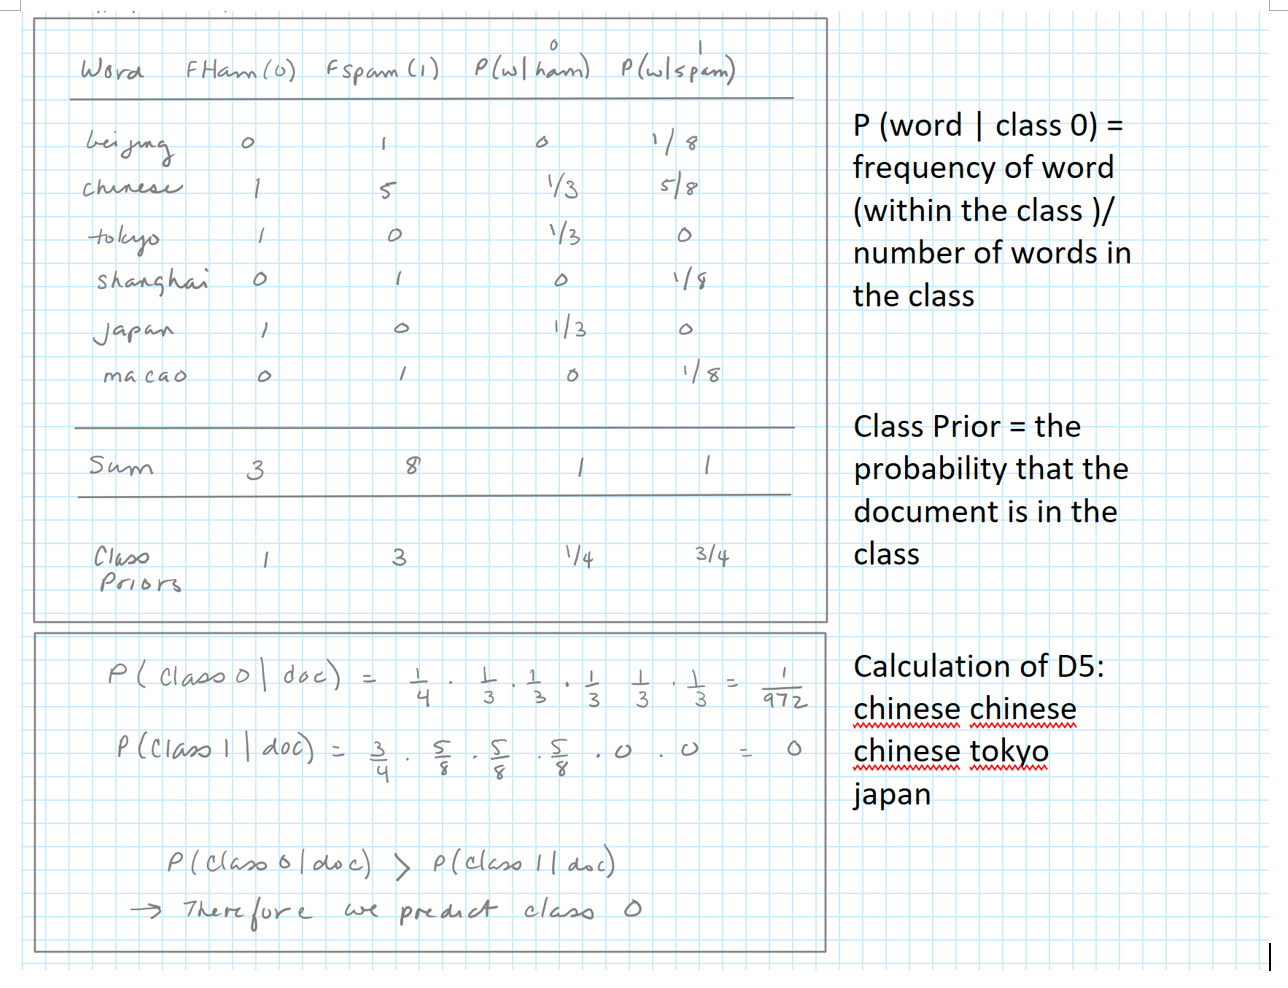

In [37]:
# <--- SOLUTION --->
# part d/e - if you didn't write out your calcuations above, embed a picture of them here:
from IPython.display import Image
Image(filename="/media/notebooks/TAship/NaiveBayesHandCalc.png")

# Question 7: Naive Bayes Inference.
In the next two questions you'll write code to parallelize the Naive Bayes calculations that you performed above. We'll do this in two phases: one MapReduce job to perform training and a second MapReduce to perform inference. While in practice we'd need to train a model before we can use it to classify documents, for learning purposes we're going to develop our code in the opposite order. By first focusing on the pieces of information/format we need to perform the classification (inference) task you should find it easier to develop a solid implementation for training phase when you get to question 8 below. In both of these questions we'll continue to use the Chinese example corpus from the textbook to help us test our MapReduce code as we develop it. Below we've reproduced the corpus, test set and model in text format that matches the Enron data.

### Q7 Tasks:
* __a) short response:__ run the provided cells to create the example files and load them in to HDFS. Then take a closer look at __`NBmodel.txt`__. This text file represents a Naive Bayes model trained (with Laplace +1 smoothing) on the example corpus. What are the 'keys' and 'values' in this file? Which record means something slightly different than the rest? The value field of each record includes two numbers which will be helpful for debugging but which we don't actually need to perform inference -- what are they? [`HINT`: _This file represents the model from Example 13.1 in the textbook, if you're having trouble getting oriented try comparing our file to the numbers in that example._]


* __b) short response:__ When performing Naive Bayes in practice instead of multiplying the probabilities (as in equation 13.3) we add their logs (as in equation 13.4). Why do we choose to work with log probabilities? If we had an unsmoothed model, what potential error could arise from this transformation?


* __c) short response:__ Documents 6 and 8 in the test set include a word that did not appear in the training corpus (and as a result does not appear in the model). What should we do at inference time when we need a class conditional probability for this word?


* __d) short response:__ The goal of our MapReduce job is to stream over the test set and classify each document by peforming the calculation from equation 13.4. To do this we'll load the model file (which contains the probabilities for equation 13.4) into memory on the nodes where we do our mapping. This is called an in-memory join. Does loading a model 'state' like this depart from the functional programming principles? Explain why or why not. From a scability perspective when would this kind of memory use be justified? when would it be unwise?


* __e) code:__ Complete the code in __`NaiveBayes/classify_mapper.py`__. Read the docstring carefully to understand how this script should work and the format it should return. Run the provided unit tests to confirm that your script works as expected then write a Hadoop streaming job to classify the Chinese example test set. [`HINT 1:` _you shouldn't need a reducer for this one._ `HINT 2:` _Don't forget to add the model file to the_ `-files` _parameter in your Hadoop streaming job so that it gets shipped to the mapper nodes where it will be accessed by your script._]


* __f) short response:__ In our test example and in the Enron data set we have fairly short documents. Since these fit fine in memory on a mapper node we didn't need a reducer and could just do all of our calculations in the mapper. However with much longer documents (eg. books) we might want a higher level of parallelization -- for example we might want to process parts of a document on different nodes. In this hypothetical scenario how would our algorithm design change? What could the mappers still do? What key-value structure would they emit? What would the reducers have to do as a last step?

### Q7 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!

> __c)__ Type your answer here!

> __d)__ Type your answer here!

> __e)__ Complete the coding portion of this question before answering 'f'.

> __f)__ Type your answer here!


### <--- SOLUTION --->
__ SOLUTION __
> __a)__ The keys in the model file are words that appear in the training corpus. The values include 4 numbers: count in `class 0`, count in `class 1`, `P(w|class0)`, `P(w|class1)`. The counts are not needed for the Naive Bayes calculation but can be helpful to check for errors in our calculations. The special record is `ClassPriors` whose value includes counts of each type of document and relative frequencies.

> __b)__ Log probabilities help us avoid floating point errors but the risk with an unsmoothed model is that we might have words that only occur in one class and have a 0 conditional probability in the other. Since we can't take `log(0)` and would need to handle that case specially.

> __c)__ We could either assign the same conditional probability to each class (eg. 0.5 for two classes) or we could simply disregard that word since multiplying the same value for each class won't ultimately affect the argmax determination.

> __d)__ Loading the model into memory is a slight departure from statelessness since we're maintaining a model state. This is forgivable since we're not updating that state at all after it gets loaded on each mapper node so there's no risk of a race condition. Furthermore our model is small, however with a really large vocabulary the model could get too large to fit in memory and we might pursue a different solution in that case.


> __f)__ If we wanted to process parts of each document in parallel then the mapper should no longer be responsible for adding the log of the class priors (because that would end up getting added multiple times-- once for each mapper that encounters a piece of the same document). Our new mapper could still perform the conditional probability look-ups (emitting  `DocID \t log(P(word|class0)),log(P(word|class1))`). Then the reducers would add the log probabilities of all the words associated with each document (from all the mappers that processed a piece of that document) and then add the ClassPriors to make a final inference.


Run these cells to create the example corpus and model.

In [25]:
%%writefile NaiveBayes/chineseTrain.txt
D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

Overwriting NaiveBayes/chineseTrain.txt


In [26]:
%%writefile NaiveBayes/chineseTest.txt
D5	1		Chinese Chinese Chinese Tokyo Japan
D6	1		Beijing Shanghai Trade
D7	0		Japan Macao Tokyo
D8	0		Tokyo Japan Trade

Overwriting NaiveBayes/chineseTest.txt


In [27]:
%%writefile NBmodel.txt
beijing	0.0,1.0,0.111111111111,0.142857142857
chinese	1.0,5.0,0.222222222222,0.428571428571
tokyo	1.0,0.0,0.222222222222,0.0714285714286
shanghai	0.0,1.0,0.111111111111,0.142857142857
ClassPriors	1.0,3.0,0.25,0.75
japan	1.0,0.0,0.222222222222,0.0714285714286
macao	0.0,1.0,0.111111111111,0.142857142857

Overwriting NBmodel.txt


In [23]:
# load the data files into HDFS
!hdfs dfs -copyFromLocal NaiveBayes/chineseTrain.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal NaiveBayes/chineseTest.txt {HDFS_DIR}

Your work for `part e` starts here:

In [29]:
# part e - do your work in NaiveBayes/classify_mapper.py first, then run this cell.
!chmod a+x NaiveBayes/classify_mapper.py

In [30]:
# part e - unit test NaiveBayes/classify_mapper.py (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


In [39]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

In [310]:
# part e - write your Hadooop streaming job here


In [32]:
# <--- SOLUTION --->
# part e - write your Hadooop streaming job here
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/chineseTest.txt \
  -output {HDFS_DIR}/chinese-output \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob7213300932398322371.jar tmpDir=null
19/08/23 15:40:07 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 15:40:07 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 15:40:08 INFO mapred.FileInputFormat: Total input paths to process : 1
19/08/23 15:40:08 INFO mapreduce.JobSubmitter: number of splits:2
19/08/23 15:40:08 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1566574597904_0004
19/08/23 15:40:08 INFO impl.YarnClientImpl: Submitted application application_1566574597904_0004
19/08/23 15:40:08 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1566574597904_0004/
19/08/23 15:40:08 INFO mapreduce.Job: Running job: job_1566574597904_0004
19/08/23 15:40:14 INFO mapreduce.Job: Job job_1566574597904_0004 running in uber mode : false
19/08/23 15:40:14 INFO mapreduce.Job:  map 0% reduce 0%
19/08

In [33]:
# part e - retrieve test set results from HDFS (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* > NaiveBayes/chineseResults.txt

In [34]:
# part e - take a look (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseResults.txt | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


<table>
<th> Expected output for the test set:</th>
<tr align=Left><td><pre>
d5	1	-8.90668134	-8.10769031	1
d6	1	-5.78074351	-4.17950237	1
d7	0	-6.59167373	-7.51170688	0
d8	0	-4.39444915	-5.56579673	0
</pre></td><tr>
</table>

# Question 8: Naive Bayes Training.
In Question 7 we used a model that we had trained by hand. Next we'll develop the code to do that same training in parallel, making it suitable for use with larger corpora (like the Enron emails). The end result of the MapReduce job you write in this question should be a model text file that looks just like the example (`NBmodel.txt`) that we created by hand above.

To refresh your memory about the training process take a look at  `6a` and `6b` where you described the pieces of information you'll need to collect in order to encode a Multinomial Naive Bayes model. We now want to retrieve those pieces of information while streaming over a corpus. The bulk of the task will be very similar to the word counting excercises you've already done but you may want to consider a slightly different key-value record structure to efficiently tally counts for each class. 

The most challenging (interesting?) design question will be how to retrieve the totals (# of documents and # of words in documents for each class). Of course, counting these numbers is easy. The hard part is the timing: you'll need to make sure you have the counts totalled up _before_ you start estimating the class conditional probabilities for each word. It would be best (i.e. most scalable) if we could find a way to do this tallying without storing the whole vocabulary in memory... Use an appropriate MapReduce design pattern to implement this efficiently! 


### Q8 Tasks:
* __a) make a plan:__  Fill in the docstrings for __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ to appropriately reflect the format that each script will input/output. [`HINT:` _the input files_ (`enronemail_1h.txt` & `chineseTrain.txt`) _have a prespecified format and your output file should match_ `NBmodel.txt` _so you really only have to decide on an internal format for Hadoop_].


* __b) implement it:__ Complete the code in __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ so that together they train a Multinomial Naive Bayes model __with no smoothing__. Make sure your end result is formatted correctly (see note above). Test your scripts independently and together (using `chineseTrain.txt` or test input of your own devising). When you are satisfied with your Python code design and run a Hadoop streaming command to run your job in parallel on the __chineseTrain.txt__. Confirm that your trained model matches your hand calculations from Question 5.


* __c) short response:__ We saw in Question 6 that adding Laplace +1 smoothing makes our classifications less sensitve to rare words. However implementing this technique requires access to one additional piece of information that we had not previously used in our Naive Bayes training. What is that extra piece of information? [`HINT:` see equation 13.7 in Manning, Raghavan and Schutze].


* __d) short response:__ There are a couple of approaches that we could take to handle the extra piece of information you identified in `c`: 1) if we knew this extra information beforehand, we could provide it to our reducer as a configurable parameter for the vocab size dynamically (_where would we get it in the first place?_). Or 2) we could compute it in the reducer without storing any bulky information in memory but then we'd need some postprocessing or a second MapReduce job to complete the calculation (_why?_). Breifly explain what is non-ideal about each of these options. 


* __e) code + short response:__ Choose one of the 2 options above. State your choice & reasoning in the space below then use that strategy to complete the code in __`NaiveBayes/train_reducer_smooth.py`__. Test this alternate reducer then write and run a Hadoop streaming job to train an MNB model with smoothing on the Chinese example. Your results should match the model that we provided for you above (and the calculations in the textbook example). __IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. 

    - [`HINT:` You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)] 
    
    - [`HINT:` To make your custom partitioning code more flexible, you can read the number of reduce tasks configuration parameter in your mapper code (instead of hard coding it). See pg 204. Hadoop Defintive Guide - Streaming environment variables]

    - [`HINT:` Don't start from scratch with this one -- you can just copy over your reducer code from part `b` and make the needed modifications]. 


### Q8 Student Answers:
> __c)__ Type your answer here!

> __d)__ Type your answer here!

> __e)__ Type your answer here!


### <--- SOLUTION --->

__SOLUTIONS__
> __c)__ We need the the vocabulary size to add to the denominator of the conditional probabilities.

> __d)__ Option 1 would require doing some EDA in advance. We could then provide the count as a parameter to the Hadoop Streaming command (see the docs for details), or we can hard code this value in the reducer code. Option 2 would require that we store all of the partial counts for each word in memory because we wouldn't be able to compute the correct conditional probability (estimates) until the reducer has already parsed all of the records because only then will it know the unique word count. This option is incompatible with using multiple reducers. 

> __e)__ We'll use the Enron EDA that we've already done to get a word count and just hard code it for simplicity. 



In [40]:
# part a - do your work in train_mapper.py and train_reducer.py then RUN THIS CELL AS IS
!chmod a+x NaiveBayes/train_mapper.py
!chmod a+x NaiveBayes/train_reducer.py
!echo "=========== MAPPER DOCSTRING ============"
!head -n 8 NaiveBayes/train_mapper.py | tail -n 6
!echo "=========== REDUCER DOCSTRING ============"
!head -n 8 NaiveBayes/train_reducer.py | tail -n 6

=========== MAPPER DOCSTRING ============
Mapper reads in text documents and emits word counts by class.
INPUT:                                                    
    DocID \t true_class \t subject \t body                
OUTPUT:                                                   
    partitionKey \t word \t class0_partialCount,class1_partialCount       
    
=========== REDUCER DOCSTRING ============
Reducer aggregates word counts by class and emits frequencies.
INPUT:            
    partitionKey \t word \t class0_partialCount,class1_partialCount # <--- SOLUTION --->
OUTPUT:                                                             # <--- SOLUTION --->
    WORD \t ham_count,spam_count,P(ham|word),P(spam|word)           # <--- SOLUTION --->
    


__`part b starts here`:__ MNB _without_ Smoothing (training on Chinese Example Corpus).

In [ ]:
# part b - write a unit test for your mapper here

In [ ]:
# part b - write a unit test for your reducer here

In [ ]:
# part b - write a systems test for your mapper + reducer together here

In [ ]:
# part b - clear (and name) an output directory in HDFS for your unsmoothed chinese NB model

In [ ]:
# part b - write your hadoop streaming job

In [ ]:
# part b - extract your results (i.e. model) to a local file

In [ ]:
# part b - print your model so that we can confirm that it matches expected results

In [16]:
# <--- SOLUTION --->
# part b - write a unit test for your mapper here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py

A	chinese	0,1
A	beijing	0,1
A	chinese	0,1
A	chinese	0,1
A	chinese	0,1
A	shanghai	0,1
A	chinese	0,1
A	macao	0,1
A	tokyo	1,0
A	japan	1,0
A	chinese	1,0
A	*docTotals	1,3
A	*wordTotals	3,8


In [4]:
# <--- SOLUTION --->
# part b - write a unit test for your reducer here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k2,2 > mapper_test_output.txt
# !cat mapper_test_output.txt
!cat mapper_test_output.txt | NaiveBayes/train_reducer.py | column -t

beijing      0,1,0.0,0.125
chinese      1,5,0.3333333333333333,0.625
japan        1,0,0.3333333333333333,0.0
macao        0,1,0.0,0.125
shanghai     0,1,0.0,0.125
tokyo        1,0,0.3333333333333333,0.0
ClassPriors  1.0,3.0,0.25,0.75


In [19]:
!cat NaiveBayes/chineseTrain.txt

D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

In [20]:
# <--- SOLUTION --->
# part b - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort | NaiveBayes/train_reducer.py | column -t

beijing      0,1,0.0,0.125
chinese      1,5,0.3333333333333333,0.625
japan        1,0,0.3333333333333333,0.0
macao        0,1,0.0,0.125
shanghai     0,1,0.0,0.125
tokyo        1,0,0.3333333333333333,0.0
ClassPriors  1.0,3.0,0.25,0.75


In [32]:
# <--- SOLUTION --->
# part b - clear (and name) an output directory in HDFS for your unsmoothed chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-train-output

Deleted /user/root/HW2/chinese-train-output


In [33]:
# <--- SOLUTION --->
# part b - write your hadoop streaming job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-train-output \
  -cmdenv PATH={PATH} \
  -numReduceTasks 2 # <-- feel free to modify the number of reducers

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob2545492988533173559.jar tmpDir=null
19/10/01 19:17:14 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/10/01 19:17:15 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/10/01 19:17:15 INFO mapred.FileInputFormat: Total input paths to process : 1
19/10/01 19:17:16 INFO mapreduce.JobSubmitter: number of splits:2
19/10/01 19:17:16 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1569547701949_0004
19/10/01 19:17:16 INFO impl.YarnClientImpl: Submitted application application_1569547701949_0004
19/10/01 19:17:16 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1569547701949_0004/
19/10/01 19:17:16 INFO mapreduce.Job: Running job: job_1569547701949_0004
19/10/01 19:17:24 INFO mapreduce.Job: Job job_1569547701949_0004 running in uber mode : false
19/10/01 19:17:24 INFO mapreduce.Job:  map 0% reduce 0%
19/10

In [34]:
# <--- SOLUTION --->
# part b - extract your results (i.e. model) to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese-train-output/part-0000* > NaiveBayes/chineseModelUnsmoothed.txt

In [35]:
# <--- SOLUTION --->
# part b - print your model so that we can confirm that it matches expected results
!cat NaiveBayes/chineseModelUnsmoothed.txt | column -t

beijing      0,1,0.0,0.125
japan        1,0,0.3333333333333333,0.0
tokyo        1,0,0.3333333333333333,0.0
ClassPriors  1.0,3.0,0.25,0.75
chinese      1,5,0.3333333333333333,0.625
macao        0,1,0.0,0.125
shanghai     0,1,0.0,0.125
ClassPriors  1.0,3.0,0.25,0.75


__`part e starts here`:__ MNB _with_ Smoothing (training on Chinese Example Corpus).

In [ ]:
# part e - write a unit test for your NEW reducer here

In [ ]:
# part e - write a systems test for your mapper + reducer together here

In [ ]:
# part e - clear (and name) an output directory in HDFS for your SMOOTHED chinese NB model

In [ ]:
# part e - write your hadoop streaming job

In [ ]:
# part e - extract your results (i.e. model) to a local file

In [51]:
# <--- SOLUTION --->
# part e - write a unit test for your NEW reducer here (NOTE, need to uncomment V in reducer code)
!chmod a+x NaiveBayes/train_reducer_smooth.py
!echo -e "A	*docTotals	1,5\nA	*wordTotals	4,4\nA	japan	1,0\nA	chinese	0,1\nA	chinese	0,1" | NaiveBayes/train_reducer_smooth.py | column -t

japan        1,0,0.0004386926957666155,0.00021934634788330776
chinese      0,2,0.00021934634788330776,0.0006580390436499232
ClassPriors  1.0,5.0,0.16666666666666666,0.8333333333333334


In [52]:
# <--- SOLUTION --->
# part e - write a systems test for your mapper + reducer together here
!cat NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort | NaiveBayes/train_reducer_smooth.py | column -t

beijing      0,1,0.00021939447125932427,0.00043830813061582295
chinese      1,5,0.00043878894251864854,0.0013149243918474688
japan        1,0,0.00043878894251864854,0.00021915406530791147
macao        0,1,0.00021939447125932427,0.00043830813061582295
shanghai     0,1,0.00021939447125932427,0.00043830813061582295
tokyo        1,0,0.00043878894251864854,0.00021915406530791147
ClassPriors  1.0,3.0,0.25,0.75


In [11]:
# <--- SOLUTION --->
# part e - clear (and name) an output directory in HDFS for your SMOOTHED chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-train-output

Deleted /user/root/HW2/chinese-train-output


In [12]:
# <--- SOLUTION --->
# part e - write your hadoop streaming job

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-train-output \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -cmdenv PATH={PATH} \
  -numReduceTasks 2 # <-- feel free to modify the number of reducers

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob1160014168044153544.jar tmpDir=null
19/10/01 22:34:35 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/10/01 22:34:35 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/10/01 22:34:36 INFO mapred.FileInputFormat: Total input paths to process : 1
19/10/01 22:34:37 INFO mapreduce.JobSubmitter: number of splits:2
19/10/01 22:34:37 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1569547701949_0006
19/10/01 22:34:38 INFO impl.YarnClientImpl: Submitted application application_1569547701949_0006
19/10/01 22:34:38 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1569547701949_0006/
19/10/01 22:34:38 INFO mapreduce.Job: Running job: job_1569547701949_0006
19/10/01 22:34:51 INFO mapreduce.Job: Job job_1569547701949_0006 running in uber mode : false
19/10/01 22:34:51 INFO mapreduce.Job:  map 0% reduce 0%
19/10

In [13]:
# <--- SOLUTION --->
# part e - extract your results (i.e. model) to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese-train-output/part-0000* > NaiveBayes/chineseModelSmoothed.txt

In [14]:
# <--- SOLUTION --->
# part e - print your model so that we can confirm that it matches expected results
!cat NaiveBayes/chineseModelSmoothed.txt | column -t

beijing      0,1,0.00021939447125932427,0.00043830813061582295
japan        1,0,0.00043878894251864854,0.00021915406530791147
tokyo        1,0,0.00043878894251864854,0.00021915406530791147
ClassPriors  1.0,3.0,0.25,0.75
chinese      1,5,0.00043878894251864854,0.0013149243918474688
macao        0,1,0.00021939447125932427,0.00043830813061582295
shanghai     0,1,0.00021939447125932427,0.00043830813061582295
ClassPriors  1.0,3.0,0.25,0.75


# Question 9: Enron Ham/Spam NB Classifier & Results.

Fantastic work. We're finally ready to perform Spam Classification on the Enron Corpus. In this question you'll run the analysis you've developed, report its performance.

### Q9 Tasks:
* __a) train/test split:__ Run the provided code to split our Enron file into a training set and testing set then load them into HDFS. [`NOTE:` _Make sure you re calculate the vocab size for just the training set!_]

* __b) train 2 models:__ Write Hadoop Streaming jobs to train MNB Models on the training set with and without smoothing. Save your models to local files at __`NaiveBayes/Unsmoothed/NBmodel.txt`__ and __`NaiveBayes/Smoothed/NBmodel.txt`__. [`NOTE:` _This naming is important because we wrote our classification task so that it expects a file of that name... if this inelegance frustrates you there is an alternative that would involve a few adjustments to your code [read more about it here](http://www.tnoda.com/blog/2013-11-23)._] Finally run the checks that we provide to confirm that your results are correct.


* __c) code:__ Recall that we designed our classification job with just a mapper. An efficient way to report the performance of our models would be to simply add a reducer phase to this job and compute precision and recall right there. Complete the code in __`NaiveBayes/evaluation_reducer.py`__ and then write Hadoop jobs to evaluate your two models on the test set. Report their performance side by side. [`NOTE:` if you need a refresher on precision, recall and F1-score [Wikipedia](https://en.wikipedia.org/wiki/F1_score) is a good resource.]


* __d) short response:__ Compare the performance of your two models. What do you notice about the unsmoothed model's predictions? Can you guess why this is happening? Which evaluation measure do you think is most relevant in our use case? [`NOTE:` _Feel free to answer using your common sense but if you want more information on evaluating the classification task checkout_ [this blogpost](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/
) or [this paper](http://www.flinders.edu.au/science_engineering/fms/School-CSEM/publications/tech_reps-research_artfcts/TRRA_2007.pdf
)]



### Q9 Student Answers:
> __d)__ Type your answer here!



### <--- SOLUTION --->
__SOLUTIONS__
> __d)__ The unsmoothed model seems to be always predicting the negative class so its accuracy is simply the proportion of non-spam emails in the test set (9/20). One reason this could happen is if the Class Prior for the negative class is larger than the Class Prior for the postive class and if there are a lot of words with 0 probability in one or the other class. The Smoothed model performs better and since we do have a mixture of predictions here we can look at the F1-score which reflects both precision and recall. In application, when developing a Spam filter we'd probably want to also look at precision and recall independently to understand whether our filter is more likely to accidentally allow a spam email to arrive in the inbox or more likely to wrongly sequester a real email.



__Test/Train split__

In [12]:
# part a - test/train split (RUN THIS CELL AS IS)
!head -n 80 data/enronemail_1h.txt > data/enron_train.txt
!tail -n 20 data/enronemail_1h.txt > data/enron_test.txt
!hdfs dfs -copyFromLocal data/enron_train.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal data/enron_test.txt {HDFS_DIR}

__Training__ (Enron MNB Model _without smoothing_ )

In [ ]:
# part b -  Unsmoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop command
!hadoop jar {JAR_FILE} \








# save the model locally
!mkdir NaiveBayes/Unsmoothed
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/NBmodel.txt

In [68]:
# <--- SOLUTION --->
# part b -  Unsmoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer.py \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/enron-model \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -cmdenv PATH={PATH}
    
# save the model locally
!mkdir NaiveBayes/Unsmoothed
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/NBmodel.txt

Deleted /user/root/HW2/enron-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob855034155836088964.jar tmpDir=null
19/08/23 16:17:13 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 16:17:13 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 16:17:14 INFO mapred.FileInputFormat: Total input paths to process : 1
19/08/23 16:17:14 INFO mapreduce.JobSubmitter: number of splits:2
19/08/23 16:17:14 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1566574597904_0012
19/08/23 16:17:14 INFO impl.YarnClientImpl: Submitted application application_1566574597904_0012
19/08/23 16:17:14 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1566574597904_0012/
19/08/23 16:17:14 INFO mapreduce.Job: Running job: job_1566574597904_0012
19/08/23 16:17:20 INFO mapreduce.Job: Job job_1566574597904_0012 running in uber mode : false
19/08/23 16:17:20 INFO mapr

In [69]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000172547666293,0.000296823983378

assistance	2,4,0.0001725476662928134,0.00029682398337785694


In [70]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,8.62738331464e-05,0.00163253190858

money	1,22,8.62738331464067e-05,0.001632531908578213


__Training__ (Enron MNB Model _with Laplace +1 smoothing_ )

In [ ]:
# part b -  Smoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model

# hadoop command
!hadoop jar {JAR_FILE} \







# save the model locally
!mkdir NaiveBayes/Unsmoothed
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

In [13]:
# <--- SOLUTION --->
# part b -  Smoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth.py \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/smooth-model \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -cmdenv PATH={PATH} \
  -numReduceTasks 2 # <-- feel free to modify the number of reducers

# save the model locally
!mkdir NaiveBayes/Smoothed
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

rm: `/user/root/HW2//smooth-model': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob380362034030580326.jar tmpDir=null
20/01/02 16:11:43 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/02 16:11:43 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/02 16:11:44 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/02 16:11:44 INFO mapreduce.JobSubmitter: number of splits:2
20/01/02 16:11:44 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1577981089921_0001
20/01/02 16:11:45 INFO impl.YarnClientImpl: Submitted application application_1577981089921_0001
20/01/02 16:11:45 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1577981089921_0001/
20/01/02 16:11:45 INFO mapreduce.Job: Running job: job_1577981089921_0001
20/01/02 16:11:56 INFO mapreduce.Job: Job job_1577981089921_0001 running in uber mode : false


In [14]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000185804533631,0.000277300205202

assistance	2,4,0.0001858045336306206,0.00027730020520215184


In [15]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,0.000123869689087,0.00127558094393

money	1,22,0.0001238696890870804,0.0012755809439298986


__Evaluation__

In [16]:
# part c - write your code in NaiveBayes/evaluation_reducer.py then RUN THIS
!chmod a+x NaiveBayes/evaluation_reducer.py

In [17]:
# part c - unit test your evaluation job on the chinese model (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py 
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | NaiveBayes/evaluation_reducer.py

d5	1	-8.90668134500626	-8.10769031284611	1
d6	1	-5.780743515794329	-4.179502370564408	1
d7	0	-6.591673732011658	-7.511706880737811	0
d8	0	-4.394449154674438	-5.565796731681498	0
d5	1	-8.90668134500626	-8.10769031284611	 True
d6	1	-5.780743515794329	-4.179502370564408	 True
d7	0	-6.591673732011658	-7.511706880737811	 True
d8	0	-4.394449154674438	-5.565796731681498	 True
Total # Documents:	4.0
True Positives:	2.0
True Negatives:	2.0
False Positives:	0.0
False Negatives:	0.0
Accuracy	1.0
Precision	1.0
Recall	1.0
F-Score	1.0


In [ ]:
# part c - Evaluate the UNSMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory

# hadoop job





# retrieve results locally

In [18]:
# <--- SOLUTION --->
# part c - Evaluate the UNSMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/nb-results

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Unsmoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/nb-results \
  -cmdenv PATH={PATH}

# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/nb-results/part-000* > NaiveBayes/Unsmoothed/results.txt

rm: `/user/root/HW2//nb-results': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob3409203252728144752.jar tmpDir=null
20/01/02 16:16:18 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/02 16:16:18 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/02 16:16:19 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/02 16:16:19 INFO mapreduce.JobSubmitter: number of splits:2
20/01/02 16:16:20 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1577981089921_0002
20/01/02 16:16:20 INFO impl.YarnClientImpl: Submitted application application_1577981089921_0002
20/01/02 16:16:20 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1577981089921_0002/
20/01/02 16:16:20 INFO mapreduce.Job: Running job: job_1577981089921_0002
20/01/02 16:16:28 INFO mapreduce.Job: Job job_1577981089921_0002 running in uber mode : false
2

In [ ]:
# part c - Evaluate the SMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory

# hadoop job





# retrieve results locally

In [77]:
# <--- SOLUTION --->
# part c - Evaluate the SMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/nb-smoothed-results

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Smoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/nb-smoothed-results \
  -cmdenv PATH={PATH}

# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/nb-smoothed-results/part-000* > NaiveBayes/Smoothed/results.txt

rm: `/user/root/HW2/nb-smoothed-results': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.1.jar] /tmp/streamjob671218802565378736.jar tmpDir=null
19/08/23 16:20:01 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 16:20:01 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
19/08/23 16:20:02 INFO mapred.FileInputFormat: Total input paths to process : 1
19/08/23 16:20:02 INFO mapreduce.JobSubmitter: number of splits:2
19/08/23 16:20:02 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1566574597904_0015
19/08/23 16:20:02 INFO impl.YarnClientImpl: Submitted application application_1566574597904_0015
19/08/23 16:20:02 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1566574597904_0015/
19/08/23 16:20:02 INFO mapreduce.Job: Running job: job_1566574597904_0015
19/08/23 16:20:08 INFO mapreduce.Job: Job job_1566574597904_0015 running in uber mode : 

In [78]:
# part c - display results 
# NOTE: feel free to modify the tail commands to match the format of your results file
print('=========== UNSMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Unsmoothed/results.txt
print('=========== SMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Smoothed/results.txt

=========== UNSMOOTHED MODEL ============
Total # Documents:	20.0
True Positives:	1.0
True Negatives:	9.0
False Positives:	0.0
False Negatives:	10.0
Accuracy	0.5
Precision	1.0
Recall	0.09090909090909091
F-Score	0.16666666666666669
=========== SMOOTHED MODEL ============
Total # Documents:	20.0
True Positives:	11.0
True Negatives:	6.0
False Positives:	3.0
False Negatives:	0.0
Accuracy	0.85
Precision	0.7857142857142857
Recall	1.0
F-Score	0.88


__`EXPECTED RESULTS:`__ 
<table>
<th>Unsmoothed Model</th>
<th>Smoothed Model</th>
<tr>
<td><pre>
# Documents:	20
True Positives:	1
True Negatives:	9
False Positives:	0
False Negatives:	10
Accuracy	0.5
Precision	1.0
Recall	0.0909
F-Score	0.1666
</pre></td>
<td><pre>
# Documents:	20
True Positives:	11
True Negatives:	6
False Positives:	3
False Negatives:	0
Accuracy	0.85
Precision	0.7857
Recall	1.0
F-Score	0.88
</pre></td>
</tr>
</table>

__`NOTE:`__ _Don't be too disappointed if these seem low to you. We've trained and tested on a very very small corpus... bigger datasets coming soon!_

# Question 10: Custom Partitioning and Secondary Sort

Now that we have our model, we can analyse the results and think about future improvements.

### Q10 Tasks:

* __a) code + short response:__ Let's look at the top ten words with the highest conditional probability in `Spam` and in `Ham`. We'll do this by writing a Hadoop job that sorts the model file (`NaiveBayes/Smoothed/NBmodel.py`). Normally we'd have to run two jobs -- one that sorts on $P(word|ham)$ and another that sorts on $P(word|spam)$. However if we slighly modify the data format in the model file then we can get the top words in each class with just one job. We've written a mapper that will do just this for you. Read through __`NaiveBayes/model_sort_mapper.py`__ and then briefly explain how this mapper will allow us to partition and sort our model file. Write a Hadoop job that uses our mapper and `/bin/cat` for a reducer to partition and sort. Print out the top 10 words in each class (where 'top' == highest conditional probability).[`HINT:` _this should remind you a lot of what we did in Question 6._]


* __b) short response:__ What do you notice about the 'top words' we printed in `a`? How would increasing the smoothing parameter 'k' affect the probabilities for the top words that you identified for 'a'. How would they affect the probabilities of words that occur much more in one class than another? In summary, how does the smoothing parameter 'k' affect the bias and the variance of our model. [`NOTE:` _you do not need to code anything for this task, but if you are struggling with it you could try changing 'k' and see what happens to the test set. We don't recommend doing this exploration with the Enron data because it will be harder to see the impact with such a big vocabulary_]

### Q10 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!

# <--- SOLUTION --->
__SOLUTIONS__
> __a)__ This mapper adds two new fields to our model file: the first is the name of the class with the higher conditional probability. We can use this field to partition our file. The second field is the conditional probability of the max class... although this information was already part of the payload by putting it in one field we can now sort on both classes simultaneously and trust that our top 10 get sorted on the appropriate value.

> __b)__ Increasing the smoothing parameter k will generally cause the conditional probabilities in each class to be closer to each other. This will have little affect on words whose probabilities were already very similar in each class but a larger effect on words that occcured much more in one class than the other. In other words increasing k reduces the variance of our model. Assuming that some of that variance we've learned is idiosynchratic to our training set, this should make our model more generalizable. However there is  risk that doing so we will increase the bias of our model because as k increases our predictions are more likely to reflect the Class Priors.

In [ ]:
# part a - write your Hadoop job here (sort smoothed model on P(word|class))

# clear output directory

# hadoop job

In [23]:
# <--- SOLUTION --->
# part a - write your Hadoop job here (sort smoothed model on P(word|class))

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/model-sort-output
# hadoop job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=4 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k4,4nr" \
  -D mapreduce.partition.keypartitioner.options="-k3,3" \
  -files NaiveBayes/model_sort_mapper.py \
  -mapper model_sort_mapper.py \
  -input {HDFS_DIR}/smooth-model \
  -output {HDFS_DIR}/model-sort-output \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -cmdenv PATH={PATH} \
  -numReduceTasks 2

Deleted /user/root/HW2/model-sort-output
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob4373669017327849285.jar tmpDir=null
20/01/02 16:23:31 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/02 16:23:31 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/02 16:23:32 INFO mapred.FileInputFormat: Total input paths to process : 2
20/01/02 16:23:32 INFO mapreduce.JobSubmitter: number of splits:2
20/01/02 16:23:32 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1577981089921_0005
20/01/02 16:23:33 INFO impl.YarnClientImpl: Submitted application application_1577981089921_0005
20/01/02 16:23:33 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1577981089921_0005/
20/01/02 16:23:33 INFO mapreduce.Job: Running job: job_1577981089921_0005
20/01/02 16:23:41 INFO mapreduce.Job: Job job_1577981089921_0005 running in uber mode : false
20/01/02 16:23:41 IN

In [ ]:
# part b - print top words in each class


In [24]:
# <--- SOLUTION --->
# part b - print top words in each class
for idx in range(2):
    print(f"============== PART-0000{idx}===============")
    !hdfs dfs -cat {HDFS_DIR}/model-sort-output/part-0000{idx} | head

============== PART-00000===============
ect	378,0,0.023473306082001735,5.546004104043037e-05	ham	0.023473306082001735	
and	258,277,0.01604112473677691,0.015417891409239643	ham	0.01604112473677691	
hou	203,0,0.0126347082868822,5.546004104043037e-05	ham	0.0126347082868822	
in	160,157,0.009971509971509971,0.008762686484387999	ham	0.009971509971509971	
for	148,153,0.00922829183698749,0.008540846320226277	ham	0.00922829183698749	
on	122,95,0.007617985878855444,0.005324163939881316	ham	0.007617985878855444	
enron	116,0,0.007246376811594203,5.546004104043037e-05	ham	0.007246376811594203	
will	113,69,0.007060572277963582,0.003882202872830126	ham	0.007060572277963582	
i	113,106,0.007060572277963582,0.00593422439132605	ham	0.007060572277963582	
this	99,90,0.00619348445435402,0.005046863734679163	ham	0.00619348445435402	
cat: Unable to write to output stream.
============== PART-00001===============
the	453,535,0.02811841942276725,0.029726581997670677	spam	0.029726581997670677	
to	350,420,0.0217

### Congratulations, you have completed HW2! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform